# NeuroNotify: Realistic Multi-Persona Contextual MDP

**IEEE Conference Paper - Experimental Notebook 2**

This experiment addresses the scientific flaws in the initial trial. We move from a single-persona "context" to a true multi-persona environment using **One-Hot Encoding (OHE)** for categorical user separation and **Double DQN (DDQN)** for training stability.

## Key Rigor Improvements:
1. **Categorical Encoding**: Users are represented as distinct dimensions, not a float spectrum.
2. **Mixed Training**: The agent is exposed to different personas randomly across episodes.
3. **Harsher Penalties**: Tripled the interruption cost (-3.0) to force strategic timing.
4. **Stability Protocol**: Implementation of DDQN to mitigate overestimation bias.

## 1. Setup and Imports

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import random

# Add src to path
sys.path.insert(0, os.path.dirname(os.path.abspath('')))

# Import our refactored modules
from src.env import NotificationEnv, UserProfile, STUDENT_PROFILE, WORKER_PROFILE, WORKAHOLIC_PROFILE
from src.networks import QNetwork, get_device
from src.agents import DQNAgent
from src.utils import (
    plot_learning_curve,
    plot_behavioral_heatmap,
    plot_dual_heatmap,
    MetricsLogger,
    compute_moving_average
)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

device = get_device()
print(f"🖥️  Using device: {device}")

## 2. Multi-Persona Definition

We use three distinct personas to challenge the agent's contextual mapping:

1. **Student (ID: 0)**: Night owl, high responsiveness.
2. **Worker (ID: 1)**: 9-5 schedule, work penalty at day.
3. **Workaholic (ID: 2)**: Long hours (8am-8pm), extreme punishment for interruption.

In [ ]:
profiles = [STUDENT_PROFILE, WORKER_PROFILE, WORKAHOLIC_PROFILE]
profile_names = ["Student", "Worker", "Workaholic"]

# Visualize schedules
fig, axes = plt.subplots(1, 3, figsize=(18, 3))
from matplotlib.patches import Patch

for i, (profile, name) in enumerate(zip(profiles, profile_names)):
    ax = axes[i]
    hours = np.arange(24)
    colors = []
    for h in hours:
        if not profile.is_awake(h): colors.append('navy')
        elif profile.is_working(h): colors.append('orange')
        else: colors.append('limegreen')
    
    ax.bar(hours, [1]*24, color=colors, edgecolor='white', linewidth=0.5)
    ax.set_title(f"{name} Schedule", fontweight='bold')
    ax.set_xticks([0, 6, 12, 18, 23])
    ax.set_yticks([])

legend_elements = [
    Patch(facecolor='navy', label='Sleeping'),
    Patch(facecolor='orange', label='Working'),
    Patch(facecolor='limegreen', label='Awake & Free')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.15))
plt.tight_layout()
plt.show()

## 3. Training: Contextual Mixed-Mode

We train for 3,000 episodes to ensure the agent converges on all three contexts. The environment now uses dynamic one-hot encoding.

In [ ]:
# Config
NUM_EPISODES = 3000
NUM_PERSONAS = 3
STATE_DIM = 4 + NUM_PERSONAS # [hour, day, recency, annoyance, OHEx3]
ACTION_DIM = 2

# Hyperparams
agent = DQNAgent(
    state_dim=STATE_DIM,
    action_dim=ACTION_DIM,
    learning_rate=0.0005, # Slightly lower for stability
    gamma=0.99,
    epsilon_decay=0.999, # Slower exploration decay for multi-context
    use_double_dqn=True,
    device=device
)

# Metric loggers per persona
global_metrics = MetricsLogger()
persona_rewards = {name: [] for name in profile_names}

print(f"🚀 Initializing Contextual DDQN on {device}...")
print(f"State Dimension: {STATE_DIM} (Includes 3-persona OHE)")

In [ ]:
for episode in tqdm(range(NUM_EPISODES), desc="Contextual Training"):
    # Randomly select a persona for this episode
    persona_idx = random.randint(0, NUM_PERSONAS - 1)
    current_profile = profiles[persona_idx]
    
    # Init Env with the selected profile
    env = NotificationEnv(user_profile=current_profile, num_users=NUM_PERSONAS)
    state, _ = env.reset()
    
    ep_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        agent.store_transition(state, action, reward, next_state, done)
        loss = agent.train_step()
        
        state = next_state
        ep_reward += reward
        
    # Global sync
    agent.decay_epsilon()
    if (episode + 1) % 10 == 0: agent.update_target()
    
    # Logging
    global_metrics.log_episode(reward=ep_reward, length=168, clicks=0, sends=0)
    persona_rewards[profile_names[persona_idx]].append(ep_reward)
    
    # Fallback logging if widgets fail
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode+1}/{NUM_EPISODES} | Avg Reward: {np.mean(global_metrics.episode_rewards[-10:]):.2f} | Epsilon: {agent.epsilon:.3f}")

print("✅ Mixed-Persona Training Complete")

## 4. Stability Analysis

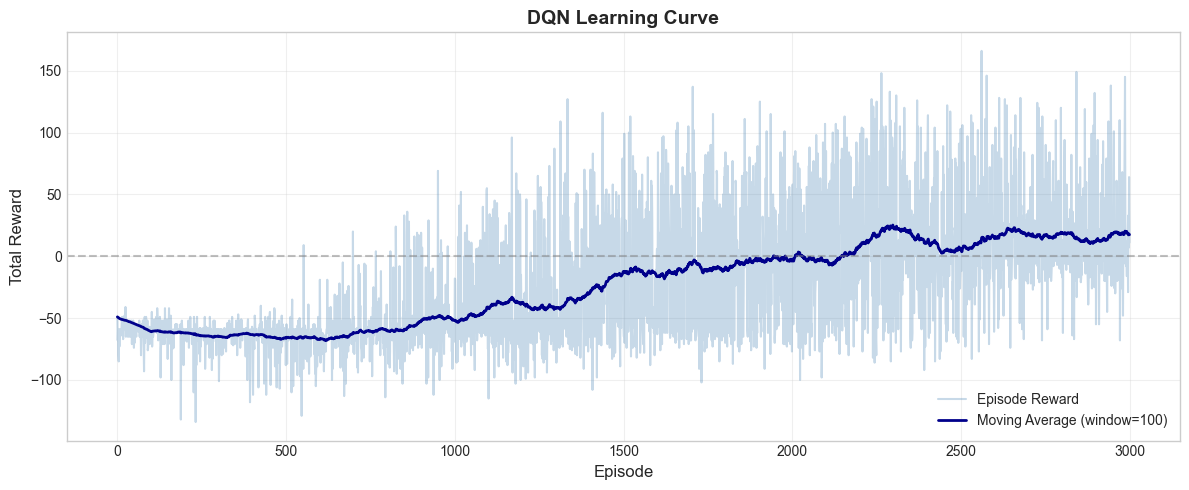

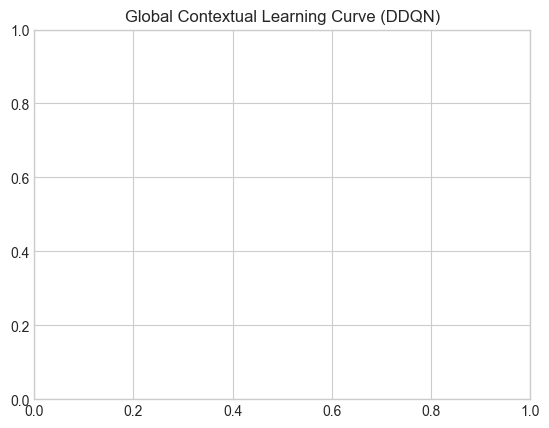

In [6]:
plot_learning_curve(global_metrics.episode_rewards, window_size=100)
plt.title("Global Contextual Learning Curve (DDQN)")
plt.show()

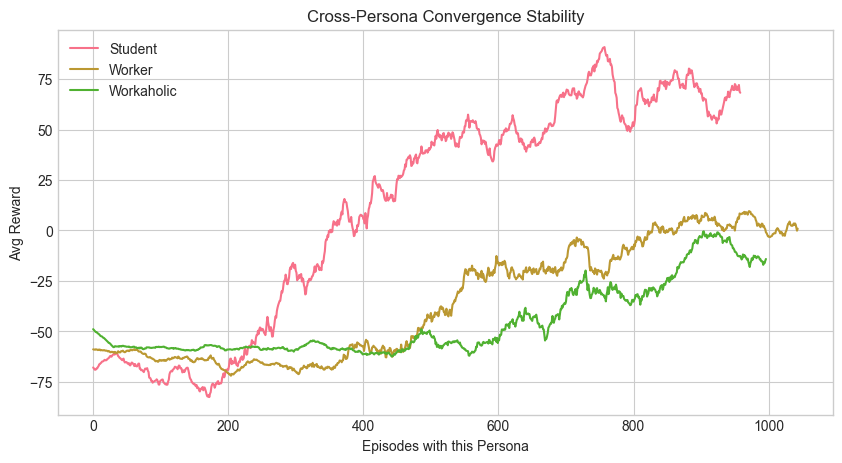

In [7]:
# Persona-specific convergence
plt.figure(figsize=(10, 5))
for name in profile_names:
    rewards = persona_rewards[name]
    if len(rewards) > 10:
        plt.plot(compute_moving_average(rewards, 30), label=name)
plt.legend()
plt.title("Cross-Persona Convergence Stability")
plt.xlabel("Episodes with this Persona")
plt.ylabel("Avg Reward")
plt.show()

## 5. Multi-Persona Behavioral Evaluation

We evaluate the frozen policy for each persona separately to see if the agent truly learned different schedules.

In [8]:
def evaluate_persona(profile, num_users=3):
    env = NotificationEnv(user_profile=profile, num_users=num_users)
    state, _ = env.reset()
    rewards = 0
    # Standard 1-week eval
    for _ in range(168):
        action = agent.act(state, epsilon=0.0)
        state, reward, term, trunc, _ = env.step(action)
        rewards += reward
        if term or trunc: break
    return rewards

print("--- Final Policy Evaluation ---")
for profile, name in zip(profiles, profile_names):
    score = evaluate_persona(profile)
    print(f"{name:12}: Evaluation Reward = {score:.2f}")

--- Final Policy Evaluation ---
Student     : Evaluation Reward = 78.00
Worker      : Evaluation Reward = 7.00
Workaholic  : Evaluation Reward = 5.00


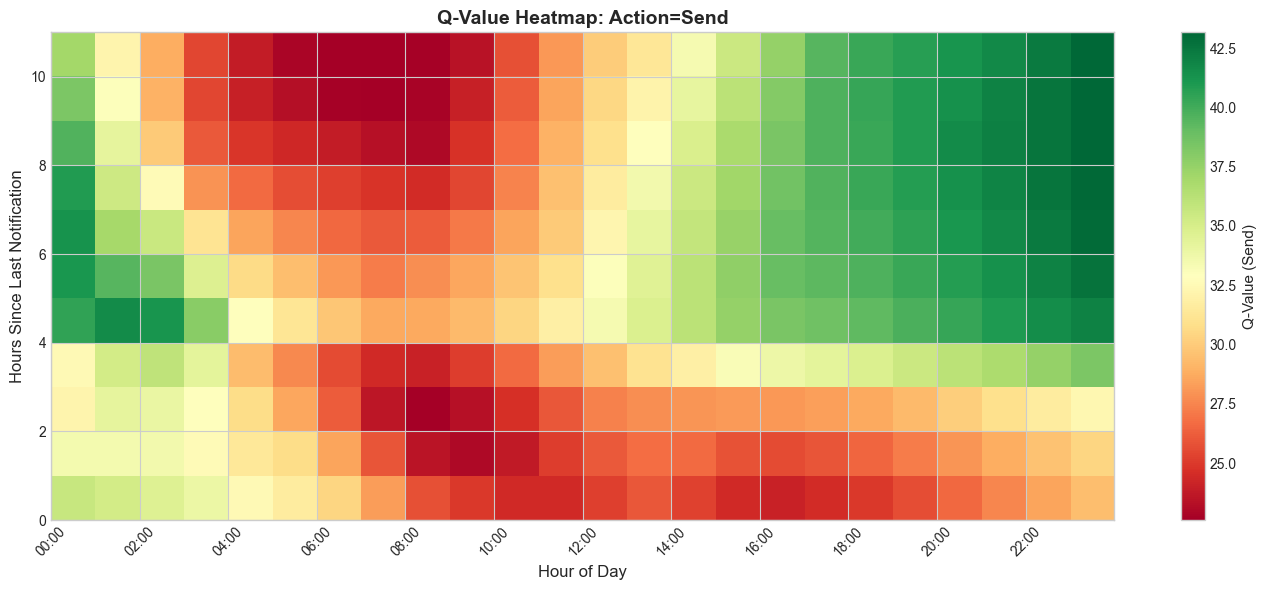

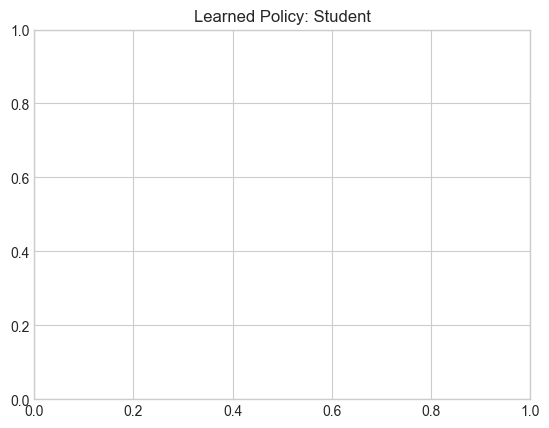

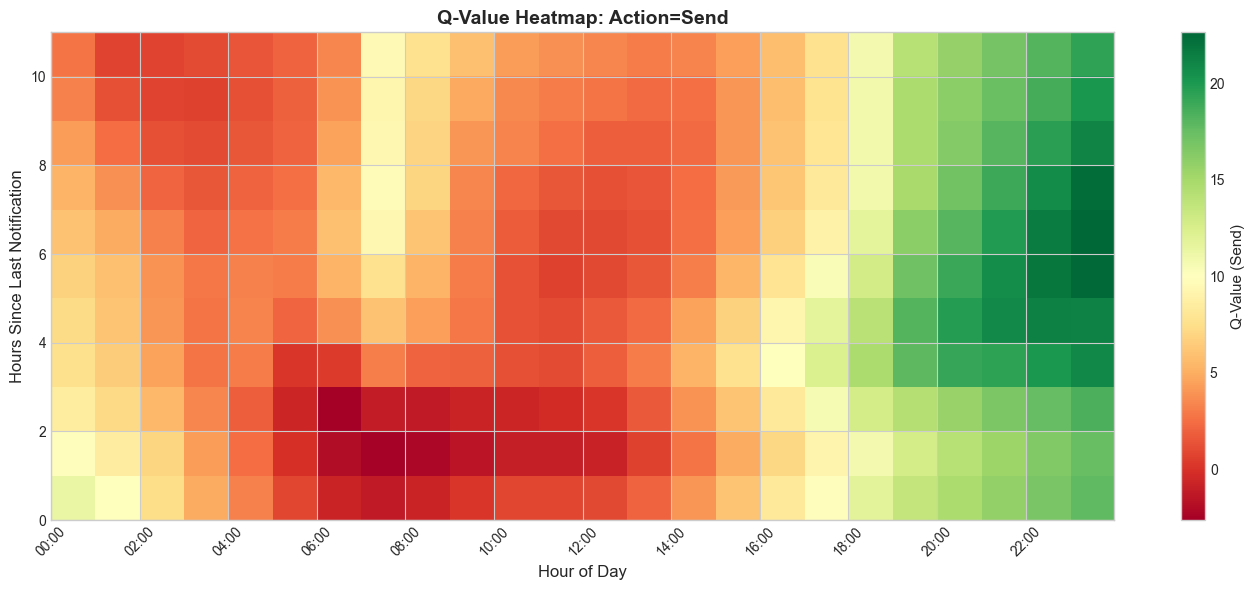

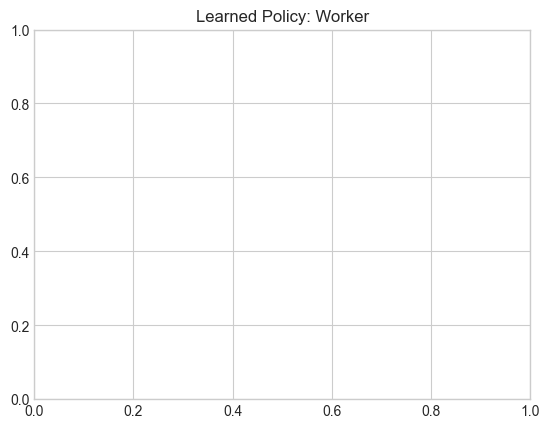

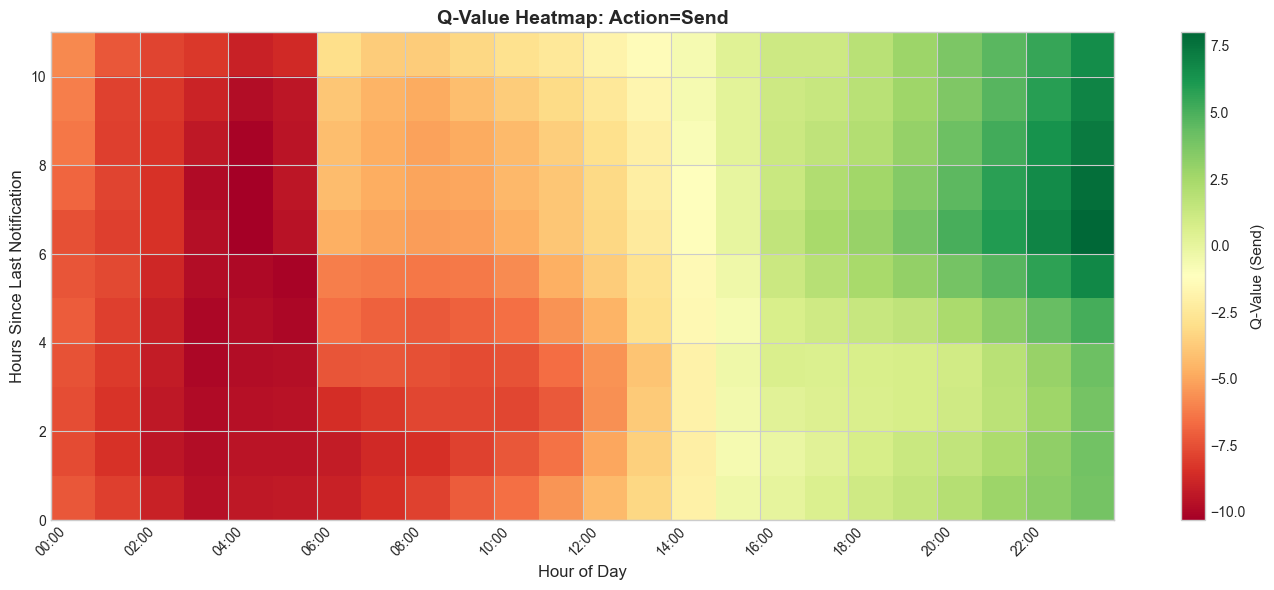

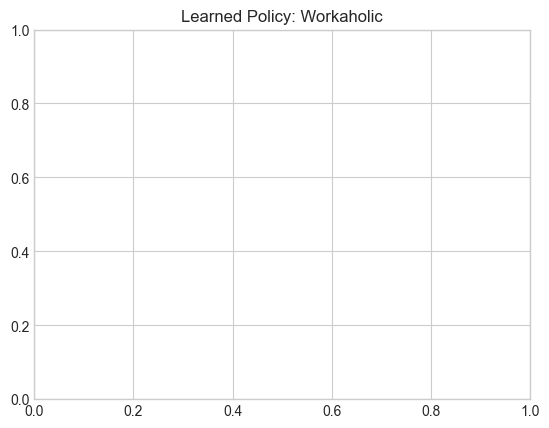

In [9]:
for profile, name in zip(profiles, profile_names):
    plot_behavioral_heatmap(agent, profile, num_users=3)
    plt.title(f"Learned Policy: {name}")
    plt.show()

In [10]:
# Save the advanced model
agent.save("models/contextual_ddqn.pth")
print("💾 Model saved to models/contextual_ddqn.pth")

💾 Model saved to models/contextual_ddqn.pth
